# Import thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import random
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import time

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Tiền xử lý

In [3]:
data_path = "/kaggle/input/creditcardfraud/creditcard.csv"
df = pd.read_csv(data_path)

In [4]:
print(df.info())
print(df.describe())
print(df.isnull().sum())  # Check missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

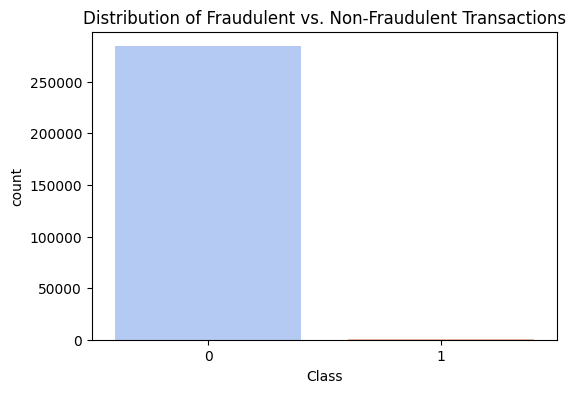

In [5]:
# 3. Check class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='coolwarm')
plt.title("Distribution of Fraudulent vs. Non-Fraudulent Transactions")
plt.show()


In [10]:
# 4. Handle missing values (if any)
data.dropna(inplace=True)  # Hoặc thay thế giá trị thiếu nếu cần

<ipython-input-10-c3fbf6c3b59e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)  # Hoặc thay thế giá trị thiếu nếu cần


In [6]:
# Phân bố giá trị giao dịch
sns.histplot(data['Amount'], bins=100, kde=True)
plt.title('Phân bố số tiền giao dịch')

# Tương quan đặc trưng (nếu đã PCA hóa thì dùng heatmap)
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap='coolwarm', annot=False)

NameError: name 'data' is not defined

In [8]:
# Chia dữ liệu thành đặc trưng và mục tiêu
X = df.drop(['Time','Class'], axis=1)
y = df['Class']

# 2. Chia theo tỉ lệ 70:20:10
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42
)

# 3. Chuẩn hóa với StandardScaler trên train
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 4. Dùng scaler đã fit để transform val và test
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



In [9]:
from imblearn.over_sampling import SMOTE

# Áp dụng SMOTE chỉ cho tập train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# GA + Stacking

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.base import clone

BASE_MODELS = {
    'lr': LogisticRegression(solver='liblinear'),
    'svc': SVC(probability=True),
    'rf': RandomForestClassifier(n_estimators=100),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'catboost': CatBoostClassifier(verbose=0),
    'lgbm': LGBMClassifier(),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

META_MODELS = {
    'lg': LogisticRegression(solver='liblinear')
}


In [12]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

def generate_meta_features(
    X: np.ndarray,
    y: np.ndarray,
    model_dict: dict,
    n_splits: int = 5
) -> np.ndarray:
    """
    Input:
      X: array (n_samples, n_features)
      y: array (n_samples,)
      model_dict: dict of name->unfitted model
    Output:
      meta_X: array (n_samples, n_base_models)
    """
    y = np.asarray(y)
    n_samples = X.shape[0]
    n_models = len(model_dict)
    meta_X = np.zeros((n_samples, n_models))
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    keys = list(model_dict.keys())

    
    for idx, name in enumerate(keys):
        model = model_dict[name]
        for train_idx, val_idx in skf.split(X, y):
            m = clone(model)
            m.fit(X[train_idx], y[train_idx])
            meta_X[val_idx, idx] = m.predict_proba(X[val_idx])[:, 1]
    return meta_X


In [13]:
# 3. Khởi tạo population trọng số

def initialize_population(pop_size: int, n_models: int):
    population = []
    for _ in range(pop_size):
        w = np.random.rand(n_models)
        w /= w.sum()
        population.append(w)
    return population

# 4. Đánh giá population trên meta-features

def evaluate(
    population: list,
    meta_X: np.ndarray,
    y_true: np.ndarray,
    metric: str = 'auc'
):
    scores = []
    for w in population:
        w = w / w.sum()
        ens = np.dot(meta_X, w)
        if metric == 'auc':
            scores.append(roc_auc_score(y_true, ens))
        elif metric == 'f1':
            scores.append(f1_score(y_true, ens > 0.5))
        else:
            raise ValueError('Unsupported metric')
    idx = np.argsort(scores)[::-1]
    return [scores[i] for i in idx], [population[i] for i in idx]

# 5. Các operators GA: selection, crossover, mutation

def selection(pop: list, scores: list):
    next_pop = [pop[0]]  # elitism
    while len(next_pop) < len(pop):
        candidates = random.sample(list(zip(pop, scores)), k=4)
        best = max(candidates, key=lambda x: x[1])[0]
        next_pop.append(best)
    return next_pop


def crossover(pop: list, prob: float):
    next_pop = [pop[0]]
    i = 1
    while i < len(pop):
        if random.random() < prob and i+1 < len(pop):
            p1, p2 = pop[i], pop[i+1]
            alpha = random.random()
            c1 = alpha*p1 + (1-alpha)*p2
            c2 = alpha*p2 + (1-alpha)*p1
            next_pop += [c1/ c1.sum(), c2/ c2.sum()]
            i += 2
        else:
            next_pop.append(pop[i])
            i += 1
    while len(next_pop) < len(pop):
        next_pop.append(random.choice(pop))
    return next_pop


def mutation(pop: list, prob: float, scale: float = 0.1):
    next_pop = [pop[0]]
    for ind in pop[1:]:
        for j in range(len(ind)):
            if random.random() < prob:
                ind[j] += np.random.normal(0, scale)
        ind[ind < 0] = 1e-4
        ind /= ind.sum()
        next_pop.append(ind)
    return next_pop

# 6. Chạy GA trên meta_X_val để tìm best_weights



def GA_weighted(
    meta_X_train: np.ndarray,
    y_train: np.ndarray,
    meta_X_val: np.ndarray,
    y_val: np.ndarray,
    pop_size: int = 50,
    generations: int = 30,
    crossover_prob: float = 0.6,
    mutation_prob: float = 0.3,
    metric: str = 'auc',
    verbose: bool = True,
    top_k: int = 3
):
    n_models = meta_X_train.shape[1]
    population = initialize_population(pop_size, n_models)

    for gen in range(generations):
        start_time = time.time()

        scores, population = evaluate(population, meta_X_val, y_val, metric)
        population = selection(population, scores)
        population = crossover(population, crossover_prob)
        population = mutation(population, mutation_prob)

        end_time = time.time()

        if verbose:
            best_score = scores[0]
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            print(f"[Gen {gen+1:02d}/{generations}] Best {metric.upper()}: {best_score:.4f} | "
                  f"Mean: {mean_score:.4f} | Std: {std_score:.4f} | Time: {end_time - start_time:.2f}s")
            print(f" → Top-{top_k} scores: {np.round(scores[:top_k], 4)}")
            print(f" → Best weights: {np.round(population[0], 4)}\n")

    return population[0]


In [ ]:
# Giả sử bạn đã có X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test

# 1. Sinh meta_X_train dùng K-fold
meta_X_train = generate_meta_features(X_train_res, y_train_res, BASE_MODELS)

# 2. Train từng base model trên full X_train_scaled
trained_models = []
for model in BASE_MODELS.values():
    m = clone(model)
    m.fit(X_train_res, y_train_res)
    trained_models.append(m)

# 3. Sinh meta_X_val và meta_X_test dùng trained_models
meta_X_val = np.column_stack([m.predict_proba(X_val_scaled)[:,1] for m in trained_models])
meta_X_test = np.column_stack([m.predict_proba(X_test_scaled)[:,1] for m in trained_models])

# 4. Chạy GA để tìm best_weights
best_weights = GA_weighted(
    meta_X_train, y_train_res,
    meta_X_val, y_val,
    pop_size=10, generations=5,
    crossover_prob=0.6, mutation_prob=0.3,
    metric='auc'
)
print('Best weights:', best_weights)

# 5. Đánh giá trên test set

final_proba = np.dot(meta_X_test, best_weights)
print('Test AUC:', roc_auc_score(y_test, final_proba))
print('Test F1 :', f1_score(y_test, final_proba > 0.5))
